In [33]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score, balanced_accuracy_score, precision_score, recall_score, auc
import shap
import muon as mu
from muon import MuData
import numpy as np

# Load your muon data objects (assuming they are stored in CSV files)
tmt_brain = mu.read('mudata_prepared_trial2/TMT_CSF_mudata.h5mu')

# Ensure 'Group' column is consistently named
proteomics = tmt_brain["proteomics"]
proteomics.obs["Group"] = proteomics.obs["Group"].map({'Control': 0, 'AD': 1})

clinical = tmt_brain["clinical"]


# Convert 'group' column to numeric
proteomics.obs["Group"] = pd.to_numeric(proteomics.obs["Group"])

# Print the shape of the combined data
print(clinical.var)

print(proteomics.obs)

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]
              Group
ID                 
TMT1_b1.127C      0
TMT1_b1.132C      0
TMT1_b1.131N      1
TMT1_b1.131C      0
TMT1_b1.129N      1
...             ...
TMT4_b5.130C      0
TMT4_b5.130N      1
TMT4_b5.128N      1
TMT4_b5.129C      0
TMT4_b5.131C      1

[784 rows x 1 columns]


/opt/anaconda3/lib/python3.12/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/opt/anaconda3/lib/python3.12/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [34]:
# Extract proteomics modality
proteomics = tmt_brain["proteomics"]
clinical = tmt_brain["clinical"]    

# Extract features from clinical modality
X_clinical = clinical.X if isinstance(clinical.X, np.ndarray) else clinical.X.toarray()
X_clinical = pd.DataFrame(clinical.obs)

# Extract features from proteomics modality
X_proteomics = proteomics.X if isinstance(proteomics.X, np.ndarray) else proteomics.X.toarray()
X_proteomics = pd.DataFrame(X_proteomics, columns=proteomics.var_names, index=proteomics.obs_names)


# Align samples (obs_names) across modalities
common_samples = clinical.obs_names.intersection(proteomics.obs_names)
X_clinical = X_clinical.loc[common_samples]
X_proteomics = X_proteomics.loc[common_samples]

# Extract 'group' column as the target variable (y)
y = proteomics.obs.loc[common_samples, 'Group']  # Assuming 'group' is in obs

# Remove 'group' column from proteomics features if it exists in var
if 'Group' in X_proteomics.columns:
    X_proteomics = X_proteomics.drop(columns=['Group'])

# Concatenate features from both modalities
X = pd.concat([X_clinical, X_proteomics], axis=1)

# Result: X contains features, and y contains labels
print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

   
print(X)
print(y)

if not X.index.equals(y.index):
    print("The indexes are not equal")  



Feature matrix shape: (784, 252)
Target vector shape: (784,)
                age  sex  Abeta42    tTau       pTau     P01024     P0C0L5  \
ID                                                                           
TMT1_b5.133N   77.8    1  1498.00  176.60  15.660000  15.308133  13.921842   
TMT1_b4.129C   55.3    0  1075.00  150.30  13.180000  15.114598  14.359233   
TMT1_b9.132N   77.0    0   739.00  213.90  21.260000  15.038211  14.548793   
TMT1_b16.130N  64.8    0   823.10  166.10  14.150000  15.220785  14.365819   
TMT1_b3.132C   82.7    1   630.30  200.00  19.290000  15.640585  14.382602   
...             ...  ...      ...     ...        ...        ...        ...   
TMT4_b5.130C   72.0    1   598.98   59.75  23.871942  15.175751  14.723523   
TMT4_b1.128N   59.0    0   152.75  109.17  35.987162  14.972327  14.470624   
TMT4_b5.129N   61.0    0   206.43  157.77  63.134782  14.978982  14.972671   
TMT4_b5.129C   79.0    1   650.64   79.92  19.481681  14.771660  14.319806   
TMT

In [35]:
print(proteomics.obs)

              Group
ID                 
TMT1_b1.127C      0
TMT1_b1.132C      0
TMT1_b1.131N      1
TMT1_b1.131C      0
TMT1_b1.129N      1
...             ...
TMT4_b5.130C      0
TMT4_b5.130N      1
TMT4_b5.128N      1
TMT4_b5.129C      0
TMT4_b5.131C      1

[784 rows x 1 columns]


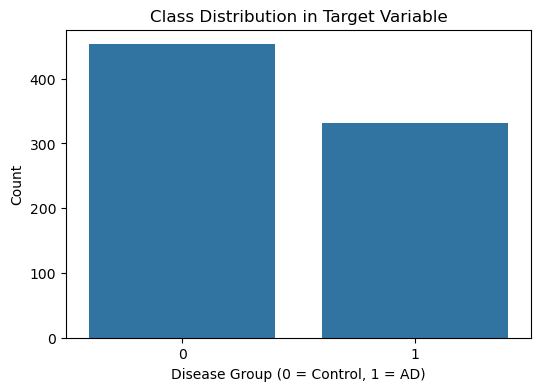

Class Distribution:
 Group
0    0.577806
1    0.422194
Name: proportion, dtype: float64


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title("Class Distribution in Target Variable")
plt.xlabel("Disease Group (0 = Control, 1 = AD)")
plt.ylabel("Count")
plt.show()

# Print actual class distribution
print("Class Distribution:\n", y.value_counts(normalize=True))


In [11]:
X = X.drop(columns=["Abeta42", "pTau", "tTau"])

In [12]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.calibration import CalibratedClassifierCV
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize models with balanced class weight
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
lr_model = LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)

# Cross-validation strategy
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store metrics for all models
model_results = []

# Feature counts to explore
feature_counts = range(5, 26)

# Parameter grids
param_grid_rf = {'n_estimators': [100], 'min_samples_split': [5]}
param_grid_lr = {'C': [0.01, 0.1], 'solver': ['liblinear', 'saga']}

for train_idx, test_idx in outer_cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # ✅ Apply SMOTE (Oversampling) to balance class distribution
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    for num_features in feature_counts:
        # ✅ Feature selection inside cross-validation
        rf_selector = SelectFromModel(rf_model, threshold=-np.inf, max_features=num_features).fit(X_train, y_train)
        X_train_selected = rf_selector.transform(X_train)
        X_test_selected = rf_selector.transform(X_test)

        # ✅ Train & Tune RandomForestClassifier
        grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=inner_cv, scoring='f1', n_jobs=-1)
        grid_search_rf.fit(X_train_selected, y_train)
        best_rf_model = grid_search_rf.best_estimator_

        # ✅ Model Calibration
        calibrated_rf = CalibratedClassifierCV(best_rf_model, method='sigmoid', cv=inner_cv)
        calibrated_rf.fit(X_train_selected, y_train)
        y_pred_proba_rf = calibrated_rf.predict_proba(X_test_selected)[:, 1]

        # ✅ Tune decision threshold
        precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba_rf)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
        best_threshold = thresholds[np.argmax(f1_scores)]

        y_pred_rf = (y_pred_proba_rf >= best_threshold).astype(int)

        model_results.append({
            'Model': 'RandomForest',
            'Precision': precision_score(y_test, y_pred_rf),
            'Recall': recall_score(y_test, y_pred_rf),
            'F1 Score': f1_score(y_test, y_pred_rf),
            'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_rf),
            'ROC AUC': roc_auc_score(y_test, y_pred_proba_rf),
            'AUC-PR': auc(recalls, precisions),
            'Num Features': num_features,
            'Best Threshold': best_threshold
        })

        # ✅ Train & Tune LogisticRegression
        grid_search_lr = GridSearchCV(lr_model, param_grid_lr, cv=inner_cv, scoring='f1', n_jobs=-1)
        grid_search_lr.fit(X_train_selected, y_train)
        best_lr_model = grid_search_lr.best_estimator_

        # ✅ Model Calibration
        calibrated_lr = CalibratedClassifierCV(best_lr_model, method='sigmoid', cv=inner_cv)
        calibrated_lr.fit(X_train_selected, y_train)
        y_pred_proba_lr = calibrated_lr.predict_proba(X_test_selected)[:, 1]

        # ✅ Tune decision threshold
        precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba_lr)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
        best_threshold = thresholds[np.argmax(f1_scores)]

        y_pred_lr = (y_pred_proba_lr >= best_threshold).astype(int)

        model_results.append({
            'Model': 'LogisticRegression',
            'Precision': precision_score(y_test, y_pred_lr),
            'Recall': recall_score(y_test, y_pred_lr),
            'F1 Score': f1_score(y_test, y_pred_lr),
            'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_lr),
            'ROC AUC': roc_auc_score(y_test, y_pred_proba_lr),
            'AUC-PR': auc(recalls, precisions),
            'Num Features': num_features,
            'Best Threshold': best_threshold
        })

# Convert results to DataFrame
results_df = pd.DataFrame(model_results)

# SHAP explanation for the best model



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

In [13]:
print(best_rf_model.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


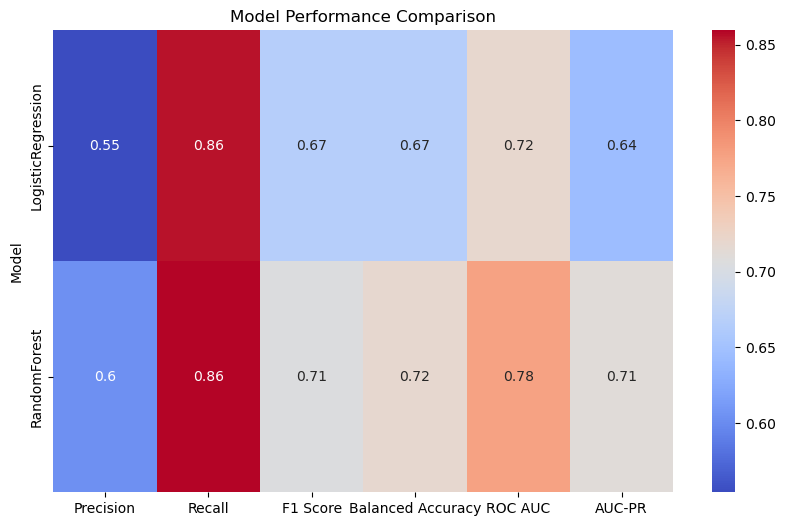

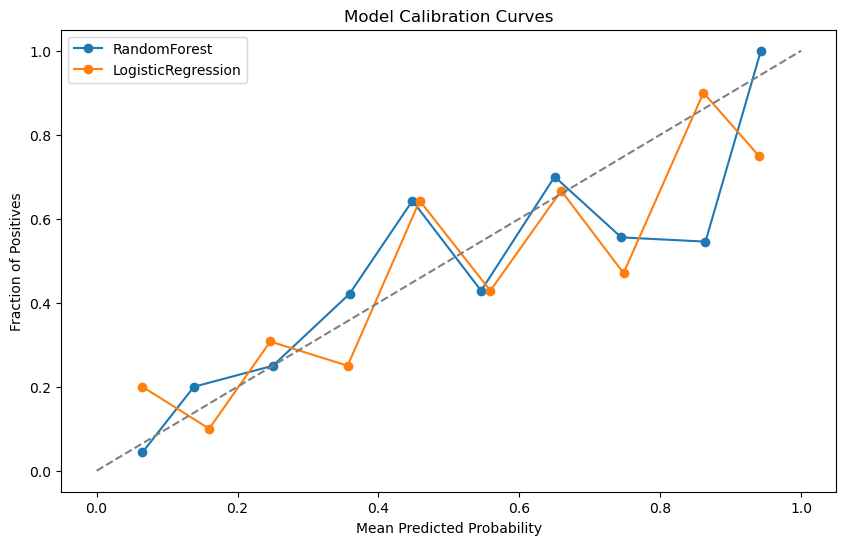

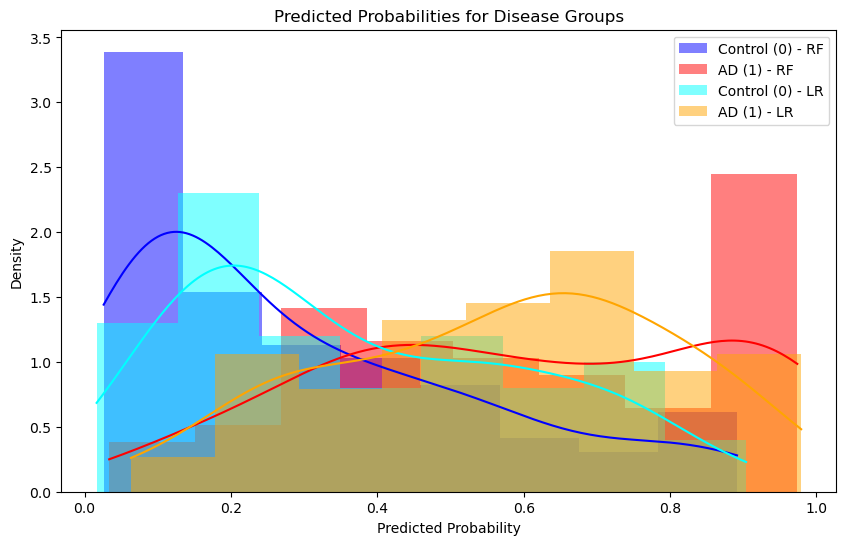

In [ ]:
# ✅ Select best models based on AUC-PR & F1 Score
best_rf = results_df[results_df['Model'] == 'RandomForest'].sort_values(by=['AUC-PR', 'F1 Score'], ascending=[False, False]).iloc[0]
best_lr = results_df[results_df['Model'] == 'LogisticRegression'].sort_values(by=['AUC-PR', 'F1 Score'], ascending=[False, False]).iloc[0]

# ✅ Plot model performance
plt.figure(figsize=(10, 6))
sns.heatmap(results_df.groupby('Model')[['Precision', 'Recall', 'F1 Score', 'Balanced Accuracy', 'ROC AUC', 'AUC-PR']].mean(), 
            annot=True, cmap='coolwarm', cbar=True)
plt.title('Model Performance Comparison')
plt.show()

# ✅ Calibration Curve Plot
from sklearn.calibration import calibration_curve

plt.figure(figsize=(10, 6))

# Random Forest Calibration
prob_true_rf, prob_pred_rf = calibration_curve(y_test, y_pred_proba_rf, n_bins=10)
plt.plot(prob_pred_rf, prob_true_rf, marker="o", label="RandomForest")

# Logistic Regression Calibration
prob_true_lr, prob_pred_lr = calibration_curve(y_test, y_pred_proba_lr, n_bins=10)
plt.plot(prob_pred_lr, prob_true_lr, marker="o", label="LogisticRegression")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Perfect calibration line
plt.title("Model Calibration Curves")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.show()

# ✅ Plot predicted probabilities for each class
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_proba_rf[y_test == 0], color='blue', label='Control (0) - RF', kde=True, stat="density", linewidth=0)
sns.histplot(y_pred_proba_rf[y_test == 1], color='red', label='AD (1) - RF', kde=True, stat="density", linewidth=0)
sns.histplot(y_pred_proba_lr[y_test == 0], color='cyan', label='Control (0) - LR', kde=True, stat="density", linewidth=0)
sns.histplot(y_pred_proba_lr[y_test == 1], color='orange', label='AD (1) - LR', kde=True, stat="density", linewidth=0)
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.title("Predicted Probabilities for Disease Groups")
plt.legend()
plt.show()


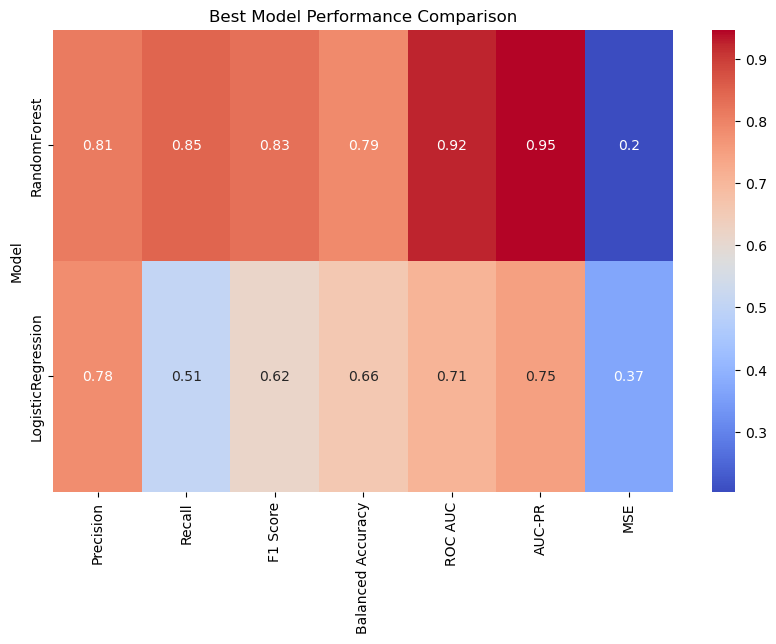

In [7]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score, precision_recall_curve, auc, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize models
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
lr_model = LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)

# Cross-validation strategy
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store metrics for all models
model_results = []

# Feature counts to explore
feature_counts = range(5, 26)  # From 5 to 25 features

# Define parameter grid for RandomForestClassifier
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 5]
}

# Define parameter grid for LogisticRegression
param_grid_lr = {
    'C': [0.01, 0.1],
    'solver': ['liblinear', 'saga']
}

for train_idx, test_idx in outer_cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    for num_features in feature_counts:
        # Feature selection using SelectFromModel with different feature counts
        rf_selector = SelectFromModel(rf_model, threshold=-np.inf, max_features=num_features).fit(X_train, y_train)
        X_train_rf_selected = rf_selector.transform(X_train)
        X_test_rf_selected = rf_selector.transform(X_test)
        
        lr_selector = SelectFromModel(lr_model, threshold=-np.inf, max_features=num_features).fit(X_train, y_train)
        X_train_lr_selected = lr_selector.transform(X_train)
        X_test_lr_selected = lr_selector.transform(X_test)
        
        # Grid search for RandomForestClassifier
        grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=inner_cv, scoring='f1',n_jobs=-1)
        grid_search_rf.fit(X_train_rf_selected, y_train)
        best_rf_model = grid_search_rf.best_estimator_
        
        # Train and evaluate RandomForestClassifier
        best_rf_model.fit(X_train_rf_selected, y_train)
        y_pred_rf = best_rf_model.predict(X_test_rf_selected)
        y_proba_rf = best_rf_model.predict_proba(X_test_rf_selected)[:, 1]
        precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_proba_rf)
        sorted_indices = np.argsort(recall_rf)
        precision_rf = precision_rf[sorted_indices]
        recall_rf = recall_rf[sorted_indices]
        auc_pr_rf = auc(recall_rf, precision_rf)
        mse_rf = mean_squared_error(y_test, y_pred_rf)
        
        model_results.append({
            'Model': 'RandomForest',
            'Precision': precision_score(y_test, y_pred_rf),
            'Recall': recall_score(y_test, y_pred_rf),
            'F1 Score': f1_score(y_test, y_pred_rf),
            'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_rf),
            'ROC AUC': roc_auc_score(y_test, y_proba_rf),
            'AUC-PR': auc_pr_rf,
            'MSE': mse_rf,
            'Num Features': num_features
        })

        # Grid search for LogisticRegression
        grid_search_lr = GridSearchCV(lr_model, param_grid_lr, cv=inner_cv, scoring='f1',n_jobs=-1)
        grid_search_lr.fit(X_train_lr_selected, y_train)
        best_lr_model = grid_search_lr.best_estimator_
        
        # Train and evaluate LogisticRegression
        best_lr_model.fit(X_train_lr_selected, y_train)
        y_pred_lr = best_lr_model.predict(X_test_lr_selected)
        y_proba_lr = best_lr_model.predict_proba(X_test_lr_selected)[:, 1]
        precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_proba_lr)
        sorted_indices = np.argsort(recall_lr)
        precision_lr = precision_lr[sorted_indices]
        recall_lr = recall_lr[sorted_indices]
        auc_pr_lr = auc(recall_lr, precision_lr)
        mse_lr = mean_squared_error(y_test, y_pred_lr)
        
        model_results.append({
            'Model': 'LogisticRegression',
            'Precision': precision_score(y_test, y_pred_lr),
            'Recall': recall_score(y_test, y_pred_lr),
            'F1 Score': f1_score(y_test, y_pred_lr),
            'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_lr),
            'ROC AUC': roc_auc_score(y_test, y_proba_lr),
            'AUC-PR': auc_pr_lr,
            'MSE': mse_lr,
            'Num Features': num_features
        })

# Convert to DataFrame
results_df = pd.DataFrame(model_results)

# Select best models based on AUC-PR (highest), fewer features (<= 25), and smallest MSE
best_rf = results_df[(results_df['Model'] == 'RandomForest') & (results_df['Num Features'] <= 25)]
best_rf = best_rf.sort_values(by=['AUC-PR', 'MSE', 'Num Features'], ascending=[False, True, True]).iloc[0]

best_lr = results_df[(results_df['Model'] == 'LogisticRegression') & (results_df['Num Features'] <= 25)]
best_lr = best_lr.sort_values(by=['AUC-PR', 'MSE', 'Num Features'], ascending=[False, True, True]).iloc[0]

# Create final DataFrame for best models
best_models_df = pd.DataFrame([best_rf, best_lr])

# Plot heatmap for the best models
plt.figure(figsize=(10, 6))
sns.heatmap(best_models_df.set_index('Model')[['Precision', 'Recall', 'F1 Score', 'Balanced Accuracy', 'ROC AUC', 'AUC-PR', 'MSE']], 
            annot=True, cmap='coolwarm', cbar=True)
plt.title('Best Model Performance Comparison')    
plt.show()

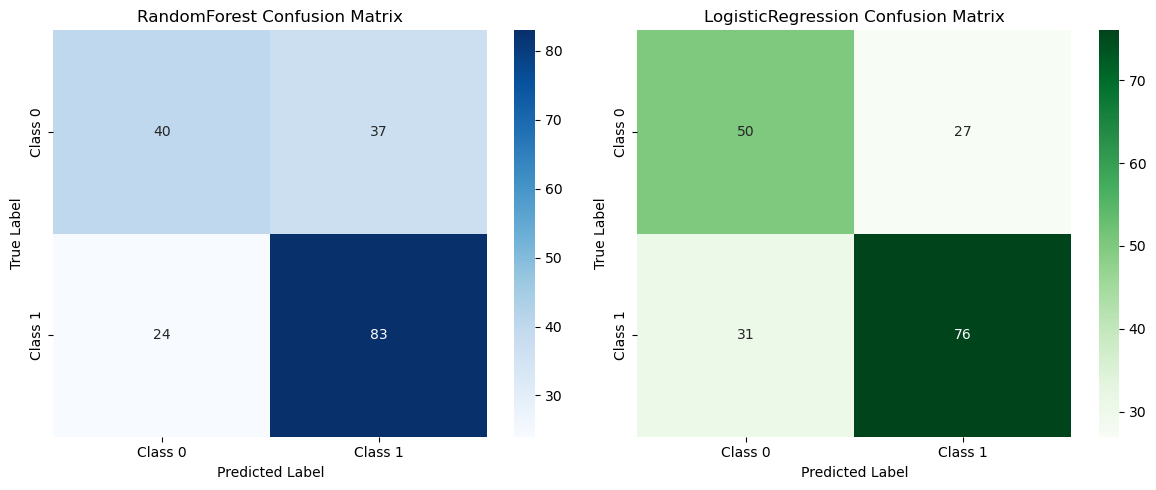

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming best_rf and best_lr contain the best models selected
best_rf_model = best_rf  # Replace with your actual best RandomForest model
best_lr_model = best_lr # Replace with your actual best LogisticRegression model

# Generate predictions for test data using the calibrated models
y_pred_rf = calibrated_rf.predict(X_test_selected)
y_pred_lr = calibrated_lr.predict(X_test_selected)

# Compute confusion matrices
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_lr = confusion_matrix(y_test, y_pred_lr)

labels = ['Class 0', 'Class 1']  # Adjust based on your dataset

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# RandomForest Confusion Matrix
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title('RandomForest Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# LogisticRegression Confusion Matrix
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title('LogisticRegression Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()
